# Advanced Lane Finding

1. Camera calibration
2. Distortion correction
3. Color & gradient threshold
4. Perspective transform

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import glob
import cv2

%matplotlib inline
%load_ext autoreload
%autoreload 2

Camera calibration

Correction images (successfully detected corners):


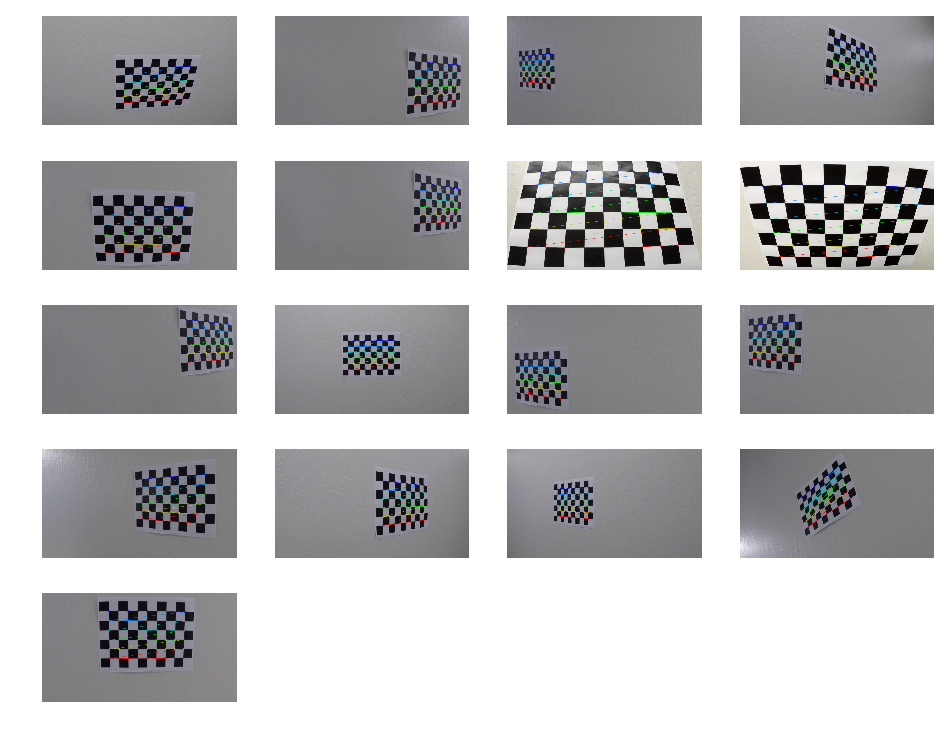


Test images (failed to detect corners):


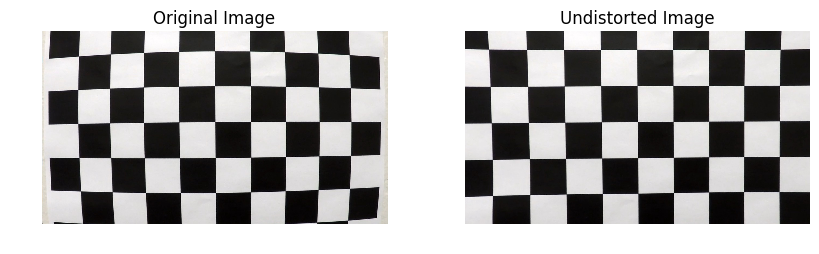

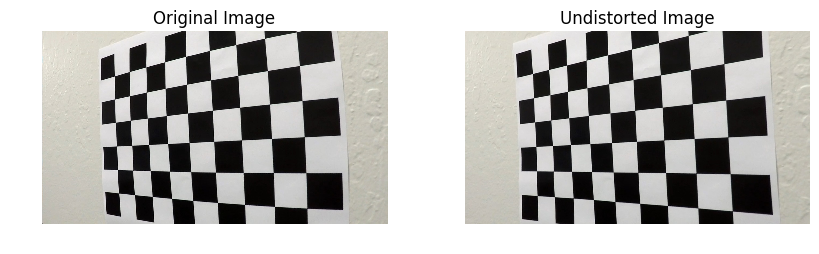

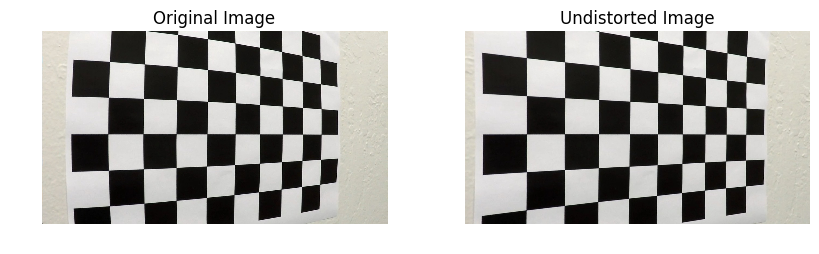

In [191]:
from camera_calibration import CameraCalibration

# Make a list of calibration images
calibrate = CameraCalibration(glob.glob('camera_cal/calibration*.jpg'), retain_calibration_images=True)

print('Correction images (successfully detected corners):')
plt.figure(figsize = (11.5, 9))
gridspec.GridSpec(5, 4)
# Step through the list and search for chessboard corners
for i, image in enumerate(calibrate.calibration_images_success):
    plt.subplot2grid((5, 4), (i // 4, i % 4), colspan=1, rowspan=1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

print('\nTest images (failed to detect corners):')
for i, image in enumerate(calibrate.calibration_images_error):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))
    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=12)
    ax2.axis('off')
    ax2.imshow(calibrate(image))
    ax2.set_title('Undistorted Image', fontsize=12)

Color & gradient threshold pipeline.

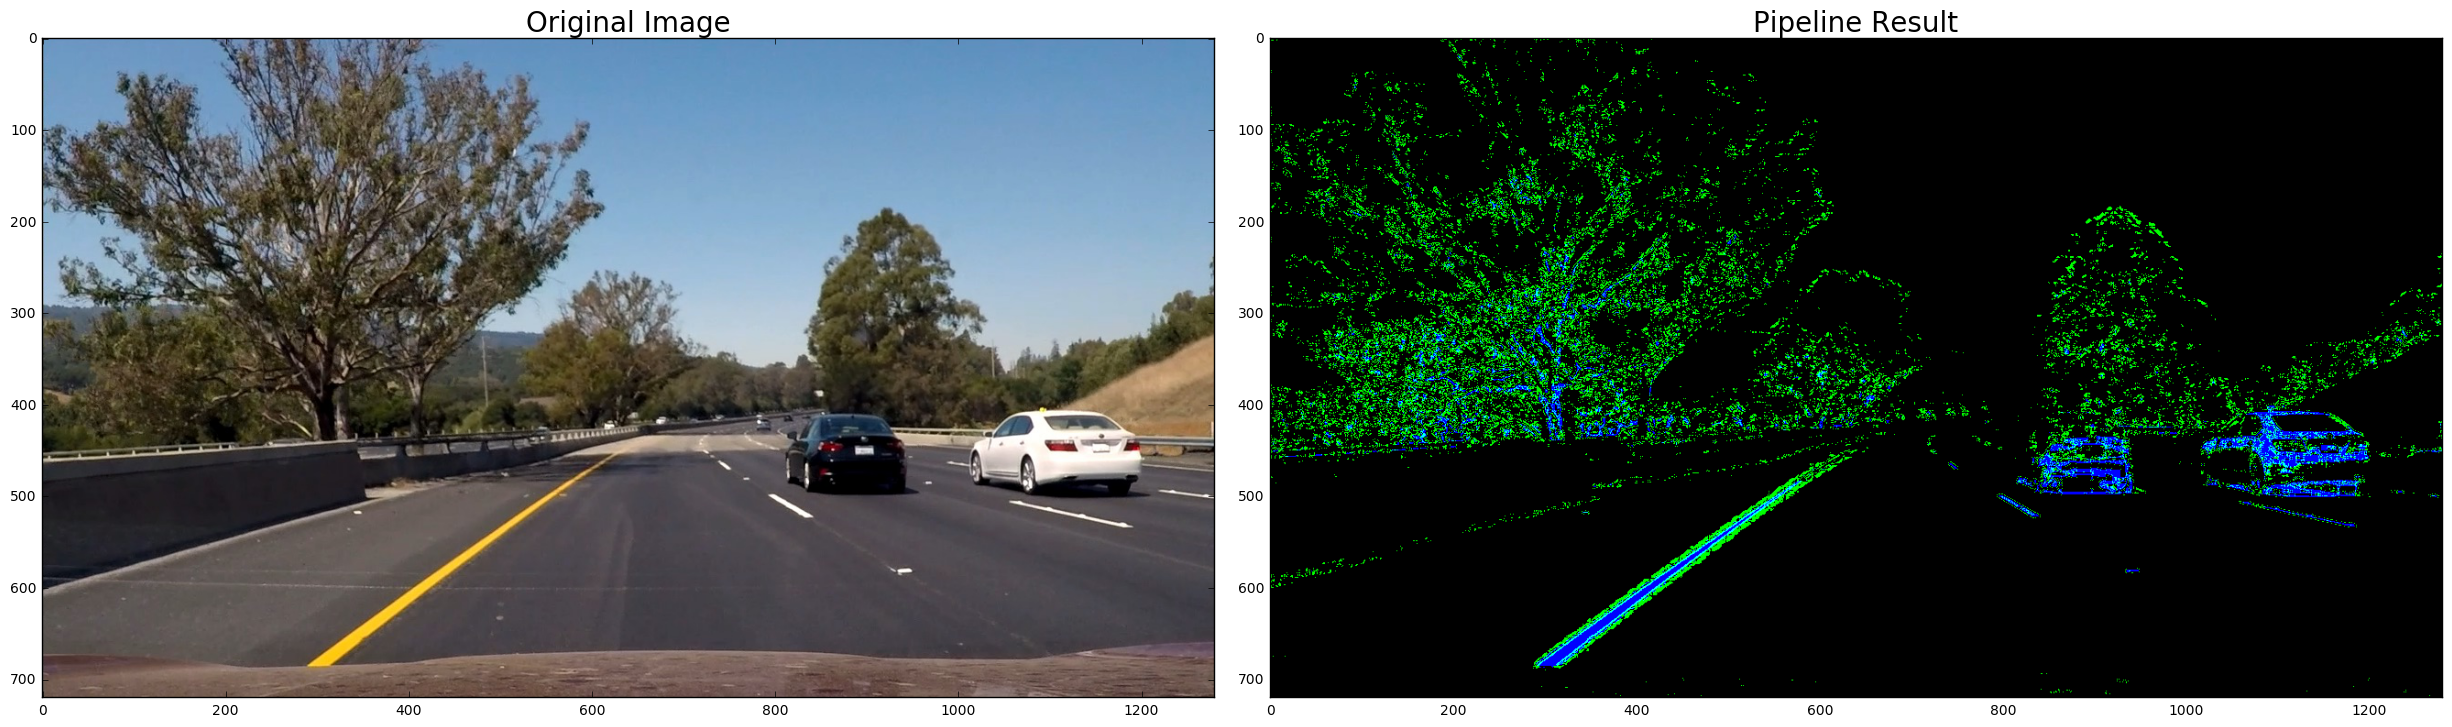

In [262]:
from gradient_edges import get_edges

image = mpimg.imread('test_images/test6.jpg')
result = get_edges(image, separate_channels=True)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Finding the lines

Radius of curvature (left): 2200.26878119
Radius of curvature (right): 1193.16363728
Distance to left line: 1.67028571429
Distance to right line: 1.80242857143


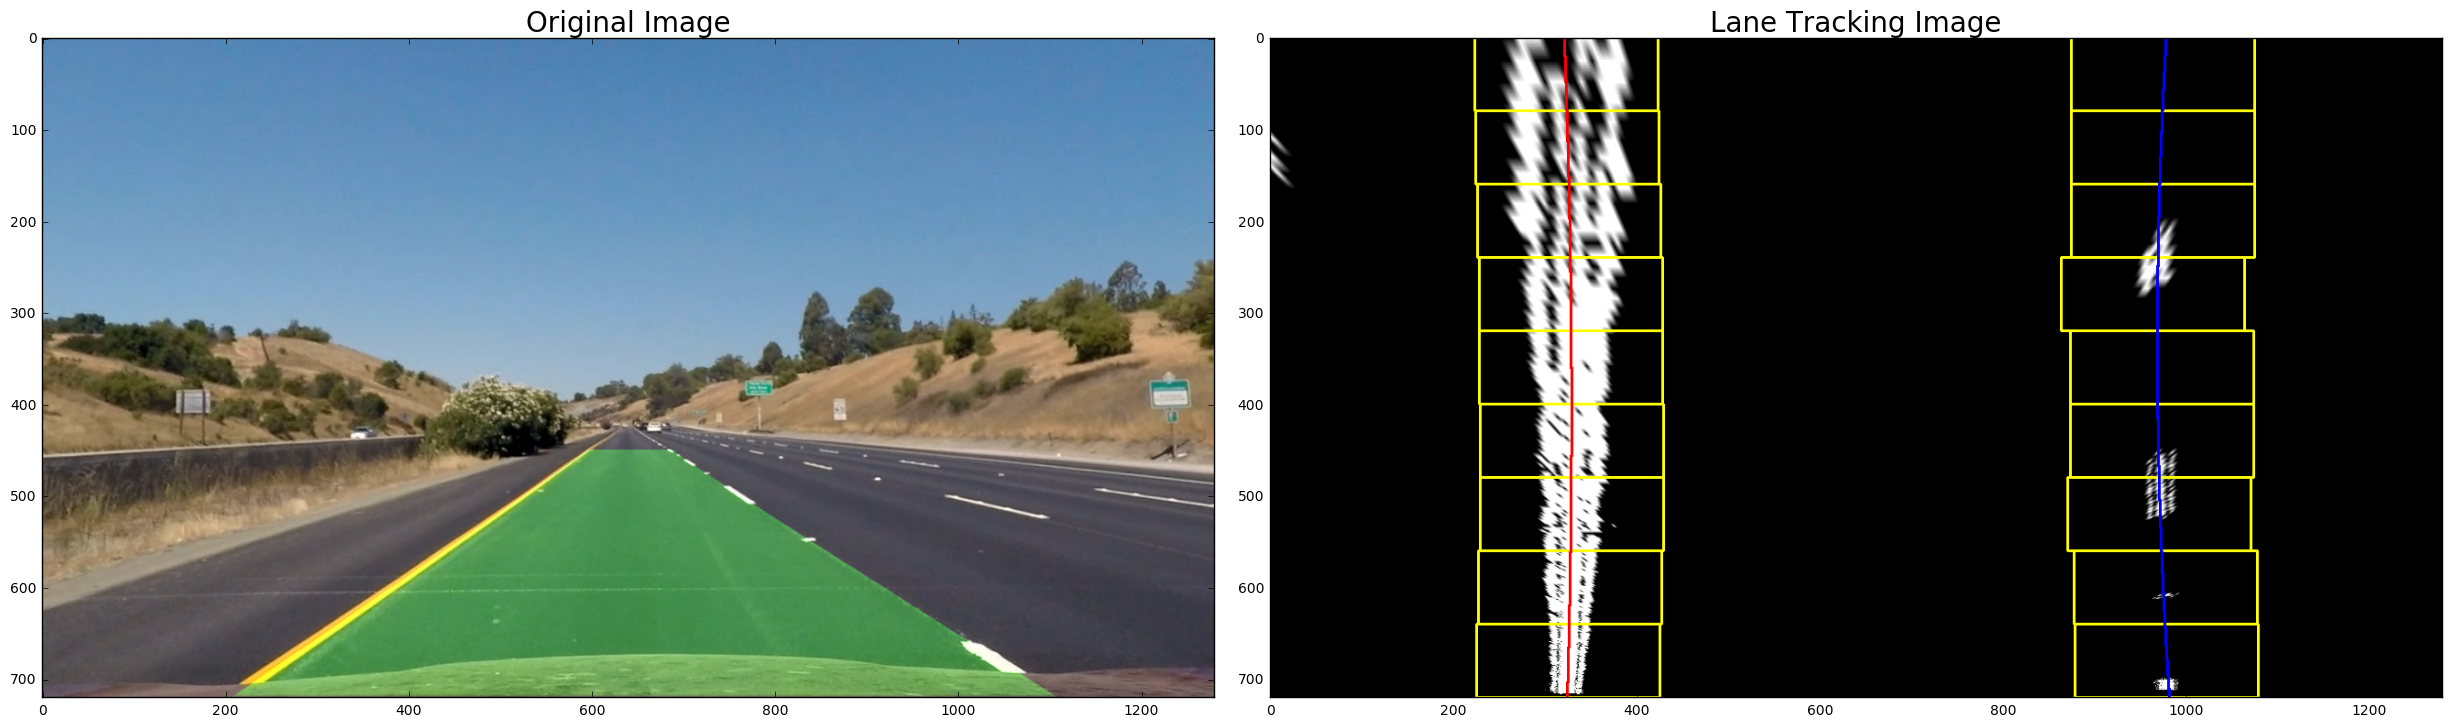

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from lanetracker.tracker import LaneTracker
from lanetracker.camera import CameraCalibration
from lanetracker.gradients import get_edges
from lanetracker.perspective import flatten_perspective

calibrate = CameraCalibration(glob.glob('camera_cal/calibration*.jpg'))
image = mpimg.imread('test_images/straight_lines1.jpg')
calibrated = calibrate(image)
edged = get_edges(calibrated)
(binary_warped, unwarp_matrix) = flatten_perspective(edged)
lane_tracker = LaneTracker(binary_warped)

statistics_image = lane_tracker.draw_statistics_overlay(binary_warped)
overlay = lane_tracker.draw_lane_overlay(calibrated, unwarp_matrix)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(overlay)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(statistics_image)
ax2.set_title('Lane Tracking Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

print('Radius of curvature (left):', lane_tracker.left.radius_of_curvature())
print('Radius of curvature (right):', lane_tracker.right.radius_of_curvature())

print('Distance to left line:', lane_tracker.left.camera_distance())
print('Distance to right line:', lane_tracker.right.camera_distance())


Tips

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0, 0, 0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 